In [1]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import argparse
import importlib.machinery
import types
import os
import pickle
from shapely import wkt, geometry
import json
import numpy as np
import sys; sys.path.append("../../methods")

from transform import simplex_ft_gpu, simplex_ft_bw_gpu
from loader import poly2ve

MEAN = 0.14807655
STD = 0.36801067

class PolyMNIST(object):
    def __init__(self, path):
        with open(os.path.join(path, "mnist_polygon_test.json"), 'r') as infile:
            self.plist = json.load(infile)
        with open(os.path.join(path, "mnist_label_test.json"), 'r') as infile:
            self.label = json.load(infile)
    def __getitem__(self, idx):
        P = wkt.loads(self.plist[idx])
        V, E = poly2ve(P)
        return V, E, self.label[idx]
    
    def get_poly(self, idx):
        P = wkt.loads(self.plist[idx])
        return P
    
    def get_label(self, idx):
        return self.label[idx]


class ShapeOptimizer(object):
    def __init__(self, polygon, model, target_cls, device):
        """
        object for optimizing polygonal shapes (MNIST experiment)
        params:
        polygon: shapely Polygon or MultiPolygon object.
        model: trained pytorch model for inference.
        target_cls: int. target class to convert to.
        device: pytorch device type
        """
        self.CPoly = CPolygon(polygon)
        self.V0 = self.V = self.CPoly.V
        self.E0 = self.E = self.CPoly.E
        self.polygon = [polygon]
        self.D = np.ones((self.E0.shape[0], 1))
        self.model = model
        self.target_tensor = torch.tensor([target_cls]).to(device)
        self.dV = None
        self.res = self.model.module.signal_sizes[0]
        self.losses = []
        
    def step(self, step_size=1e-3, sign=-1):
        '''
        combines _get_grad and _step.
        sign = 1 for maximizing score
        sign = -1 for minimizing score
        '''
        assert(sign==1 or sign==-1)
        self._get_grad()
        self._step(step_size=step_size, sign=sign)

    def _step(self, step_size=1e-3, sign=-1, check=True, shuffle=True):
        """
        Take a step toward gradient direction. 
        params:
        step_size: gradient step size
        sign: 1 or -1, to go maximize or minimize value
        check: bool. whether to enforce no-intersection constraint
        shuffle: whether to traverse points in random order during checked updates
        """
        if not check:
            self.V += sign * step_size * self.dV
        else:
            if shuffle:
                seq = np.random.permutation(self.V.shape[0])
            else:
                seq = np.arange(self.V.shape[0])
            for idx in seq:
                V_step = self.V.copy()
                V_step[idx] += sign * step_size * self.dV[idx]
                if self.CPoly.newPolygon(V_step).is_valid:
                    self.V = V_step
        
        self.polygon.append(self.CPoly.newPolygon(self.V))

    def _get_grad(self):
        """
        Compute gradient of loss function w.r.t. into vertices
        params:
        self
        """
        # compute frequencies from V, E
        Freq = simplex_ft_gpu(self.V, self.E, self.D, (self.res+2, self.res+2), t=(1,1), j=2)
        Freq = np.squeeze(Freq)
        half = int(self.res/2+1)
        Freq = np.concatenate((Freq[:half], Freq[half+2:]), axis=0)
        Freq = np.stack([np.real(Freq), np.imag(Freq)], axis=-1).astype(np.float32)
        Freq = np.expand_dims(np.expand_dims(Freq, 0), 0) # pad to shape (batch(1), channel(1), res, res)
        F_ten = torch.tensor(Freq, requires_grad=True)

        # compute loss wrt. target class
        self.model.eval()
        model.zero_grad()
        logits = self.model(F_ten)
        loss = F.cross_entropy(logits, self.target_tensor)
        loss.backward()
        self.losses.append(loss.item()) # save loss at current iteration

        # compute grad on V
        dF = np.squeeze(F_ten.grad.detach().cpu().numpy()) # shape (28, 15, 2 (real+imag))
        dF = dF[..., 0] + (1j)*dF[..., 1]
        dF = dF[:, :-1] # shape (28, 14)
        dF = np.expand_dims(dF, axis=-1) # shape (28, 14, 1)
        self.dV = simplex_ft_bw_gpu(dF, self.V, self.E, self.D, (self.res, self.res), t=(1,1), j=2)
        self.dV = self.dV[:self.V.shape[0]]
                
        
class CPolygon(object):
    def __init__(self, polygon):
        self.polygon = polygon
        self.V, self.E, self.E_segs = self.getVE()
        self.npoly = len(self.E_segs)
        
    def edgeList(self, startid, length, flip=False):
        # helper function to create edge list
        p1 = np.arange(startid, startid+length)
        p2 = p1 + 1
        p2[-1] = startid
        if not flip:
            return np.stack((p1, p2), axis=-1)
        else:
            return np.flipud(np.stack((p2, p1), axis=-1))
        
    def singlePolygon(self, P):
        # helper function for processing a single polygon instance
        assert(isinstance(P, geometry.polygon.Polygon))
        v = []
        e = []
        ecount = 0
        # exterior
        v_ex = np.array(P.exterior)[:-1]
        e_ex = self.edgeList(0, v_ex.shape[0])
        v.append(v_ex)
        e.append(e_ex)
        ecount += v_ex.shape[0]
        # interiors
        for int_ in P.interiors:
            v_in = np.array(int_)
            e_in = self.edgeList(ecount, v_in.shape[0], flip=False)
            v.append(v_in)
            e.append(e_in)
            ecount += v_in.shape[0]
        v = np.concatenate(v, axis=0)
        e_segs = e
        e = np.concatenate(e, axis=0)
        if not P.exterior.is_ccw:
            e = np.concatenate([e[:, 1:2], e[:, 0:1]], axis=-1) # flip e
        return v, e, e_segs
    
    def getVE(self):
        E_segs = []
        if isinstance(self.polygon, geometry.polygon.Polygon):
            V, E, e_segs = self.singlePolygon(self.polygon)
            E_segs.append(e_segs)
        elif isinstance(self.polygon, geometry.multipolygon.MultiPolygon):
            V = []
            E = []
            E_segs = []
            ecount = 0
            for P in self.polygon.geoms:
                v, e, e_segs = self.singlePolygon(P)
                V.append(v)
                E.append(e+ecount)
                for s in e_segs:
                    s += ecount
                E_segs.append(e_segs)
                ecount += v.shape[0]
            V = np.concatenate(V, axis=0)
            E = np.concatenate(E, axis=0)
            
        return V, E, E_segs
    
    def newPolygon(self, V):
        np.testing.assert_array_equal(V.shape, self.V.shape)
        polys = []
        for loops in self.E_segs:
            # exterior loop
            ext_loop = loops[0][:, 0]
            ext_v = geometry.asLinearRing(V[ext_loop])
            ints_v = []
            for i in range(1, len(loops)):
                int_loop = loops[i][:, 0]
                int_v = geometry.asLinearRing(V[int_loop])
                ints_v.append(int_v)
            poly = geometry.Polygon(ext_v, ints_v)
            polys.append(poly)
        if len(polys) == 1:
            return polys[0]
        else:
            return geometry.MultiPolygon(polys)
            

In [3]:
from matplotlib import pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from numpy import asarray, concatenate, ones
from shapely.geometry import *

def ring_coding(ob):
    # The codes will be all "LINETO" commands, except for "MOVETO"s at the
    # beginning of each subpath
    n = len(ob.coords)
    codes = ones(n, dtype=Path.code_type) * Path.LINETO
    codes[0] = Path.MOVETO
    return codes

def pathify(polygon):
    # Convert coordinates to path vertices. Objects produced by Shapely's
    # analytic methods have the proper coordinate order, no need to sort.
    vertices = concatenate(
                    [asarray(polygon.exterior)]
                    + [asarray(r) for r in polygon.interiors])
    codes = concatenate(
                [ring_coding(polygon.exterior)]
                + [ring_coding(r) for r in polygon.interiors])
    return Path(vertices, codes)

def showPolygon(polygon):
    fig = plt.figure(num=1, figsize=(4, 4))
    ax = fig.add_subplot(111)

    path = pathify(polygon)
    patch = PathPatch(path, facecolor='#cccccc', edgecolor='#999999')

    ax.add_patch(patch)

    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_aspect(1.0)
    
    return fig, ax    

In [4]:
# parse arguments
parser = argparse.ArgumentParser(description='MNIST shape optimization')
parser.add_argument('-l', '--logdir', type=str, default="logs/log-10-21-2018_12-29-07", help='log directory path')
parser.add_argument('-s', '--step_size', type=float, default=1e-3, help='step size for shape optimization')
parser.add_argument('--no_cuda', action='store_true', help='do not use cuda')
parser.add_argument('--seed', type=int, default=1, metavar='S', help='random seed (default: 1)')

args = parser.parse_args('')

use_cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")

# Load the model
loader = importlib.machinery.SourceFileLoader('LeNet5', os.path.join(args.logdir, "model.py"))
mod = types.ModuleType(loader.name)
loader.exec_module(mod)

model = mod.LeNet5(mean=MEAN, std=STD)
if use_cuda:
    model = nn.DataParallel(model)
model.to(device)
model.load_state_dict(torch.load(os.path.join(args.logdir, "checkpoint_final.pth.tar"))['state_dict'])

# Shape Optimization
pmnist = PolyMNIST("data/polyMNIST")
idx = 2
P = pmnist.get_poly(idx)
label = pmnist.get_label(idx)
print("Original Label: {}".format(label))
optim = ShapeOptimizer(P, model, target_cls=7, device=device)

Original Label: 1


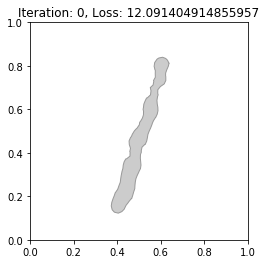

In [5]:
%matplotlib inline
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = showPolygon(optim.polygon[-1])
def update(frame_number):
    optim.step(1e-3)
    path = pathify(optim.polygon[-1])
    patch = PathPatch(path, facecolor='#cccccc', edgecolor='#999999')
    ax.cla()
    ax.add_patch(patch)
    ax.set_title("Iteration: {0}, Loss: {1}".format(frame_number, optim.losses[-1]))
    print("Iter: {0}".format(frame_number), end='\r')
anim = FuncAnimation(fig, update, interval=20, frames=50)

In [6]:
HTML(anim.to_html5_video())

In [8]:
print(optim.losses)

[12.091404914855957, 7.705355167388916, 2.364912509918213, 1.533743143081665, 1.1881611347198486, 0.8586113452911377, 0.642348051071167, 0.5306658744812012, 0.47168421745300293, 0.42763376235961914, 0.3900175094604492, 0.3561229705810547, 0.3107309341430664, 0.26755332946777344, 0.2375955581665039, 0.2143087387084961, 0.1952824592590332, 0.17971515655517578, 0.16797590255737305, 0.15749502182006836, 0.14824676513671875, 0.1387653350830078, 0.12906932830810547, 0.11986160278320312, 0.11120319366455078, 0.10251140594482422, 0.09541988372802734, 0.0896763801574707, 0.08499336242675781, 0.08022117614746094, 0.07661676406860352, 0.07365703582763672, 0.07110929489135742, 0.06873750686645508, 0.0665435791015625, 0.06413745880126953, 0.06222105026245117, 0.06022834777832031, 0.058414459228515625, 0.0567631721496582, 0.05503702163696289, 0.05366230010986328, 0.052469730377197266, 0.0514373779296875, 0.05025005340576172, 0.04915761947631836, 0.04782247543334961, 0.0466313362121582, 0.04551935195

In [7]:
optim.polygon[-1].is_valid

True